## Forecasting Stock Prices with time-series data
- the following LSTM Data Science project draws inspiration from the following literature review and uplevel's mini datascience project
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227222
- https://dataprojects.uplevel.work

In the project's first section, we will be covering the following:
1. Getting Data
2. Preliminary Data Visualization
3. Data Preparation
4. Getting the AR, I and MA orders

### 1. Importing Necessary Libraries

In [15]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
%matplotlib inline

### 1.1. Getting necessary finance data

In [3]:
# getting s&p500 data
snp500 = yf.download(tickers=['^GSPC'], start='2000-01-03', end='2019-07-01')

[*********************100%***********************]  1 of 1 completed


### 2. Data Exploration for S&P500's historical data

In [4]:
snp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4903 entries, 2000-01-03 to 2019-06-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4903 non-null   float64
 1   High       4903 non-null   float64
 2   Low        4903 non-null   float64
 3   Close      4903 non-null   float64
 4   Adj Close  4903 non-null   float64
 5   Volume     4903 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 397.2 KB
              Open         High          Low        Close    Adj Close  \
count  4903.000000  4903.000000  4903.000000  4903.000000  4903.000000   
mean   1537.095955  1545.925748  1527.560141  1537.277962  1537.277962   
std     544.026525   544.704304   543.269875   544.124869   544.124869   
min     679.280029   695.270020   666.789978   676.530029   676.530029   
25%    1145.964966  1154.494995  1138.515015  1146.059998  1146.059998   
50%    1349.579956  1357.510010  1337.520020  1349.589966  1

<AxesSubplot:>

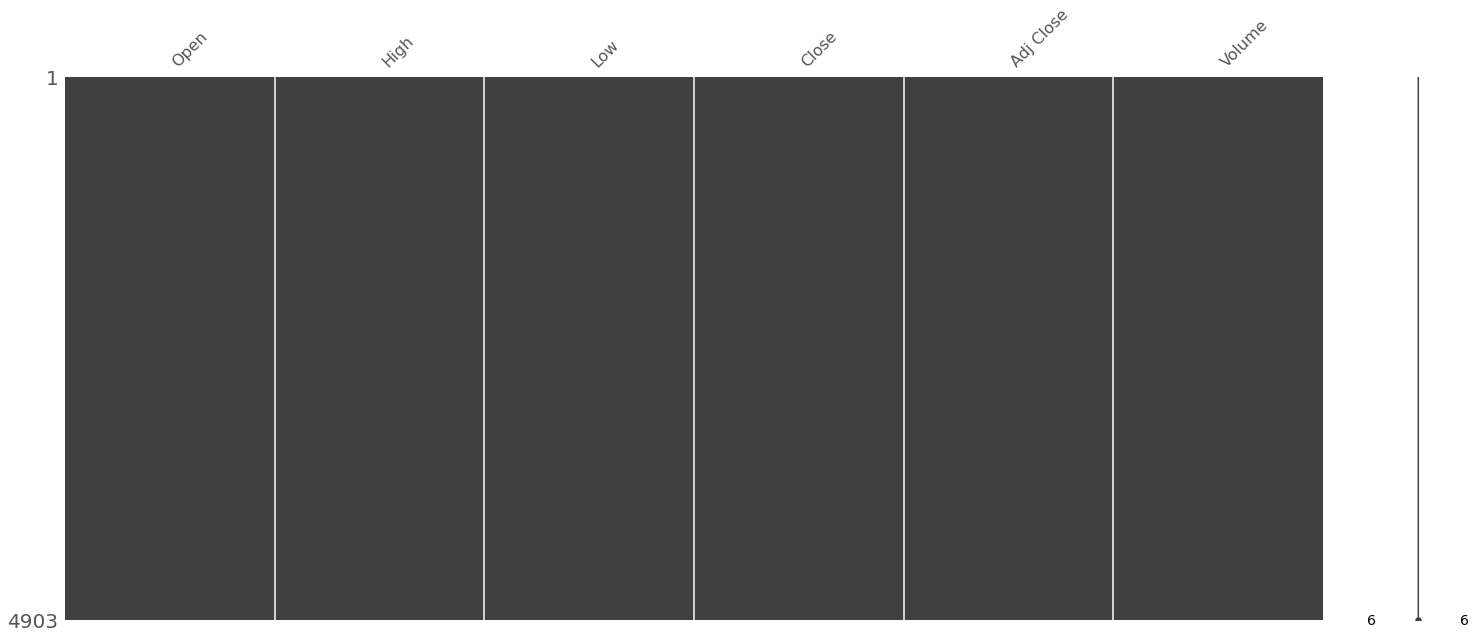

In [25]:
# check datatypes of dataframe
snp500.info()

# getting statistical values of our data
print(snp500.describe())

# checking for any missing data
msno.matrix(snp500)

There are no missing trading days.

### 3. Preliminary Data Visualization

Prior to building charts, we will preset some global chart settings that will remain consistent

In [19]:
# plot style
plt.style.use('ggplot')

# plot title size
plt.rc('axes', titlesize=18)

# plot font size
plt.rc('font', size=13)

# plot figure size
matplotlib.rcParams['figure.figsize'] = (18, 9)

<AxesSubplot:xlabel='Date', ylabel='Open'>

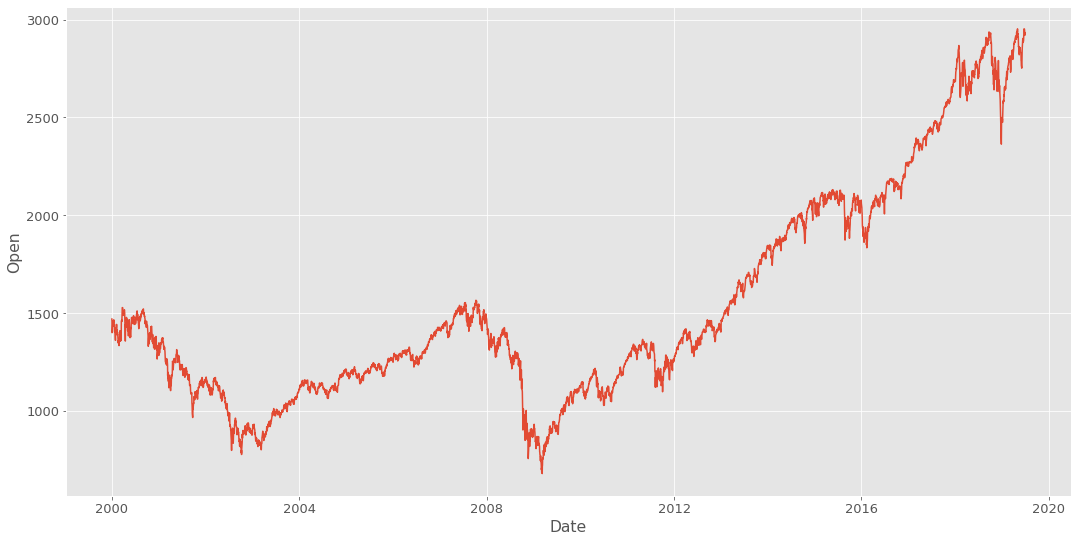

In [7]:
sns.lineplot(data=snp500, x=snp500.index, y='Open')

### 3.1. Data Preparation

The S&P500 historical data only contains weekday dates (understandably) which means that it will need to develop solutions to handle the issue.

There are many ways to handle non-trading days in time series forecasting
1. Backfill (current strategy)
2. Interpolate
3. Ignore non-trading days and assume that 1 trading year has only 52 weeks (or 104 days). However, there is another issue of holidays which the stock market does not trade either. 

As such, the next intuitive solution is to back fill Open prices because actual trading prices remains the same (not talking about premarket trading etc) throughout the weekend and only changes during market open on Monday.


**Backfill**

Fills missing data with newer data (e.g. Saturday & Sunday with following Monday's value)

In [10]:
# back filling data with frequency set to 1 day
snp500_backfilled = snp500.asfreq(freq='1D', method='backfill')
snp500_backfilled

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
...,...,...,...,...,...,...
2019-06-24,2951.419922,2954.919922,2944.050049,2945.350098,2945.350098,3136250000
2019-06-25,2945.780029,2946.520020,2916.010010,2917.379883,2917.379883,3578050000
2019-06-26,2926.070068,2932.590088,2912.989990,2913.780029,2913.780029,3478130000


<AxesSubplot:xlabel='Date', ylabel='Open'>

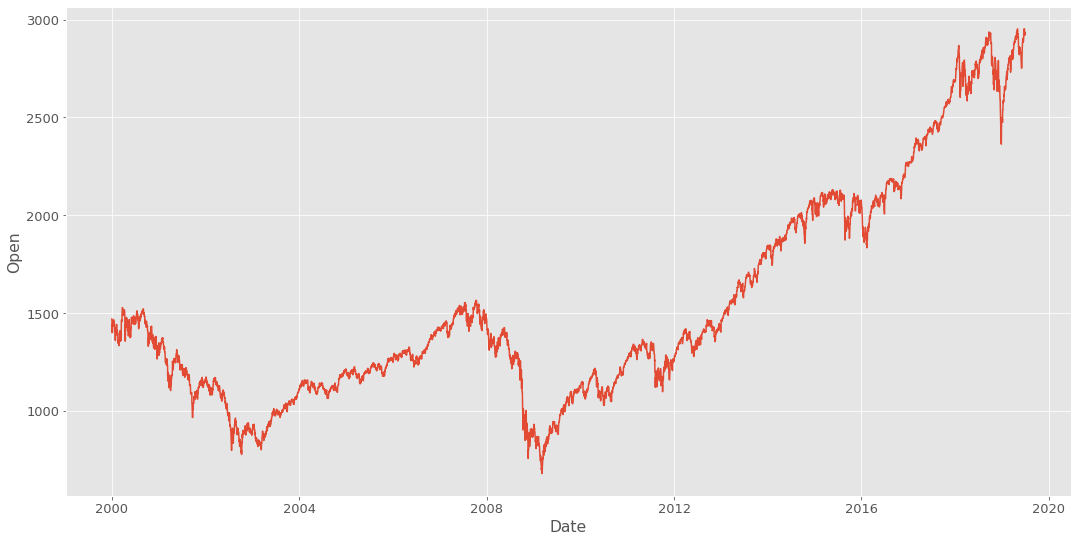

In [11]:
# re-plotting backfilled data to observe difference
sns.lineplot(data=snp500_backfilled, x=snp500_backfilled.index, y='Open')

Plot still looks the same as compared to non-backfilled time series data, but we definitely can observe that the data is not stationary as there are some form of seasonality coupled with an increasing trend over time.

### 3.2. Determining lag term (d) - Stationarity

Differencing is taking the difference between time period (t) and the time period before (t-1). Therefore, differencing of order 1 would be Y(t) - Y(t-1)

To find the first differencing price:

In [12]:
snp500_first_differencing = (
    snp500_backfilled
    .assign(first_difference=lambda x: x.Open.diff(periods=1))
    .dropna(axis=0)
)

snp500_first_differencing.head()

,Open,High,Low,Close,Adj Close,Volume,first_difference
Date,,,,,,,
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-14.030029
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,-55.799927
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,2.689941
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1.339966
2000-01-08,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000,38.020020


### 3.3. Visualizing 1st order differencing of historical opening price

<AxesSubplot:xlabel='Date', ylabel='first_difference'>

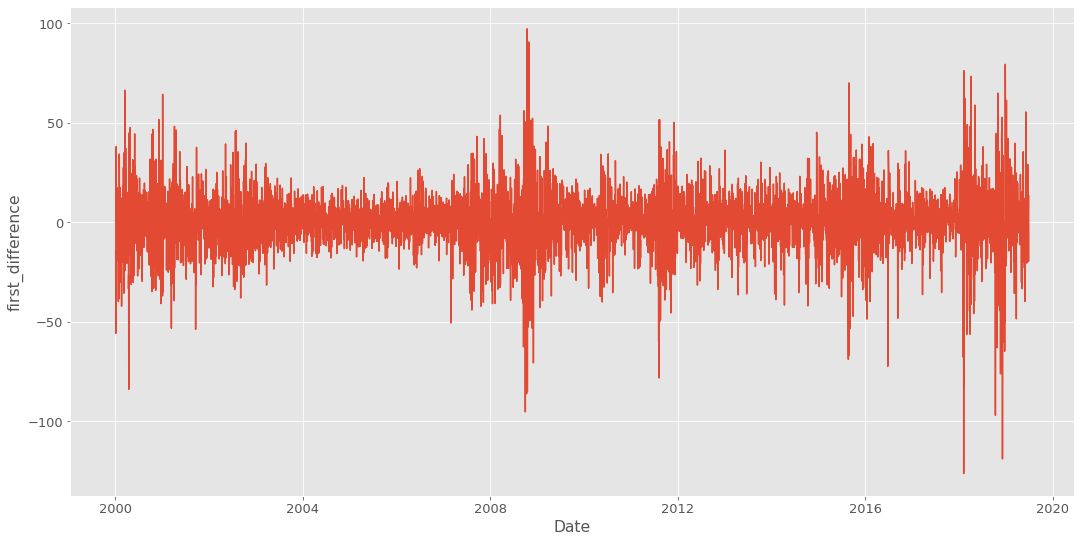

In [13]:
sns.lineplot(data=snp500_first_differencing, x=snp500_first_differencing.index, y='first_difference')

A visual inspection of the first-order difference open price now looks to be stationary, with the differenced values now flunctuating somewhat closely around 0. To statistically test if the first order differencing produced a stationary time series, we will be using the Augmented Dickey Fuller Test (ADF).

### Augmented Dickey Fuller Test (ADF) and Unit Root
Source 1: https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

Source 2: https://www.statisticshowto.com/unit-root/

Fundamentally a statistical significance test, it is a common test to determine if a time series is stationary. ADF belongs to a category of tests called 'Unit Root Test' which is a proper method for testing stationary in time series. The presence of unit roots in the time series tells us that the time-series is NOT stationary which can have serious issues like:

- Spurious Regressions (high r-squared values) even though data is uncorrelated
- Errant Behaviour due to assumptions for analysis not being valid (e.g. t-rations will not follow t-distribution)

**Other Unit Root Tests include:**
1. Dickey Fuller Test
2. Elliott-Rothenberg-Stock Test
3. Schmidt-Phillips Test
4. Phillips-Perron Test
5. Zivot-Andrews Test

For the purposes of this project, I will only be testing for stationarity using the ADF test. 

In [16]:
first_differencing_result = adfuller(snp500_first_differencing['first_difference'])

print('------------First Order Differencing------------')
print(f'ADF Statistic: {first_differencing_result[0]}\n')
print(f'P-Value %: {first_differencing_result[1]}\n')
print('Critical Values: ')
for key, val in first_differencing_result[4].items():
    print(key, val)


no_differencing_comparison = adfuller(snp500_first_differencing['Open'])

print('\n------------Original Time Series------------')
print(f'ADF Statistic: {no_differencing_comparison[0]}\n')
print(f'P-Value %: {no_differencing_comparison[1]}\n')
print('Critical Values: ')
for key, val in no_differencing_comparison[4].items():
    print(key, val)

------------First Order Differencing------------
ADF Statistic: -33.68375607023376

P-Value %: 0.0

Critical Values: 
1% -3.431270194514558
5% -2.8619466530279003
10% -2.5669864573263372

------------Original Time Series------------
ADF Statistic: 0.8798217709767703

P-Value %: 0.9928212631671681

Critical Values: 
1% -3.431270324020347
5% -2.8619467102503315
10% -2.5669864877867923


Given that: 
- Null hypothesis(H0) Time series plot is **Not** stationary
        --The null hypothesis assumes the presence of unit root
- Alternative hypothesis (H1) is that the plot is stationary.

Given that the level of significance (alpha) is 0.05, we will reject the null hypothesis if the p-value is < 0.05 and accept the alternative hypothesis. Which in this case, the p-value is 0.0 which rejects the assumption of presence of unit root in our differenced time series. Drawing contrast from the time series prior to a first order differencing which had a p-value of 0.99. 

Finally, we will be using **d=1** for our ARIMA model.

### Plotting the Partial Autocorrelation Function (PACF)

PACF expresses the correlation between observations made at two points in time (series and the lag of itself)  while accounting for any influence from other data points. Its used to determine the optimal number of terms (p) to be used in the Auto Regressive component of the ARIMA model

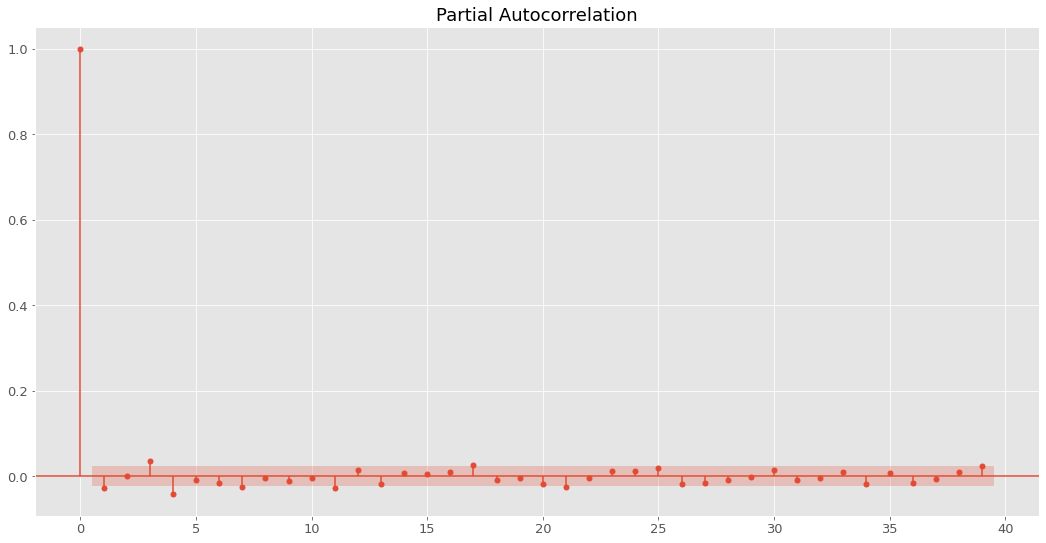

In [20]:
# plotting PACF of first order differencing
plot_pacf(snp500_first_differencing['first_difference'])
plt.show()

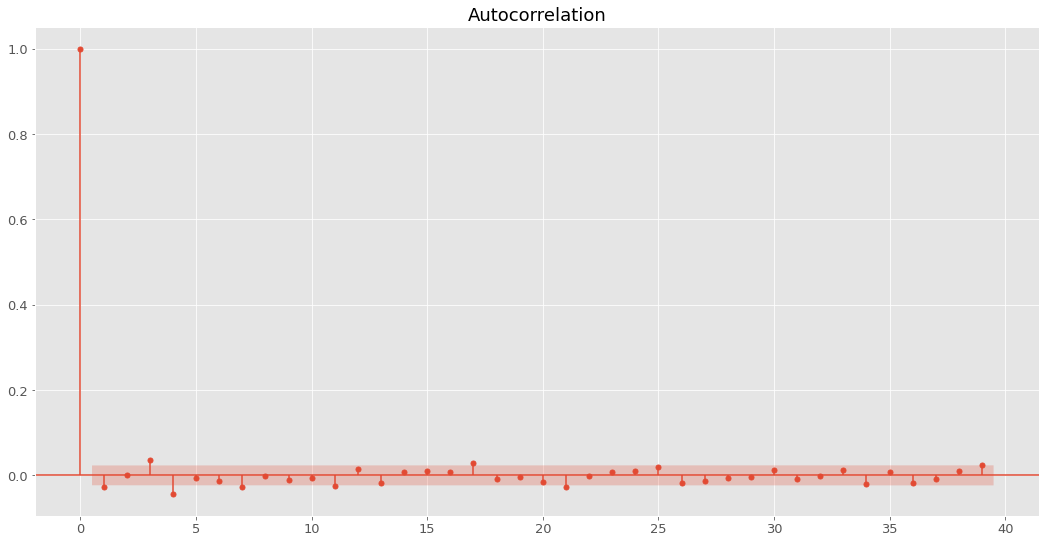

In [21]:
plot_acf(snp500_first_differencing['first_difference'])
plt.show()